Q Function:
create a convnet that adds a third layer for the border
like the soft policy
Approach: Big filters
    create 3 or so layers with 64 random 11x11x3 filters each, relu
    eventually combine with (1,1) layer, tanh

- read games as lines from file
- for each game:
    - create the 8 symmetries as a single batch
    - feed the two last states into the learning loop with the value according to terminal state
    - distance: (max_a(Q) - R_terminal)^2
-

In [1]:
import numpy as np
import tensorflow as tf
from domoku.board import GomokuBoard
from domoku import data
from domoku.data import create_binary_rep
from domoku.tools import GomokuTools as Gt
from domoku.policies.maximal_criticality import MaxCriticalityPolicy

policy = MaxCriticalityPolicy(15)

2022-05-28 07:24:50.550613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [2]:
SIZE = 15

In [3]:
with open("heuristics.gmk", 'r') as f:
    trajectories = f.read().splitlines()

In [4]:
all_stones_t = [data.transform(Gt._string_to_stones(trajectory), 15, rot, ref)
                for rot in range(4)
                for ref in [False, True]
                for trajectory in trajectories]
len(all_stones_t)

128

# States and their values

The last three board states of every trajectory lend themselves to immediate value learning.

In [5]:
def display(_stones):
    GomokuBoard(n=SIZE, stones=_stones, disp_width=6).display()

In [6]:
n_sample = 105
stones = all_stones_t[n_sample]

## -1: White lost

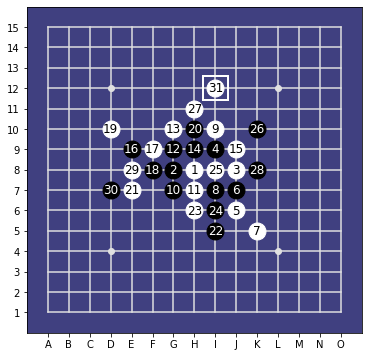

In [7]:
display(stones)

## +1: Black to move and win immediately

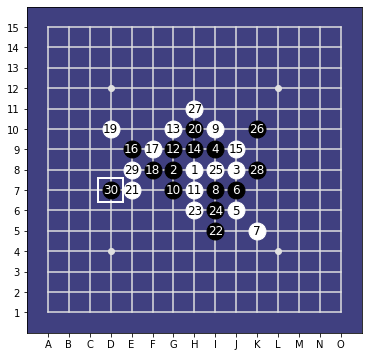

In [8]:
display(stones[:-1])

## -1: White to move with no chance to turn things around

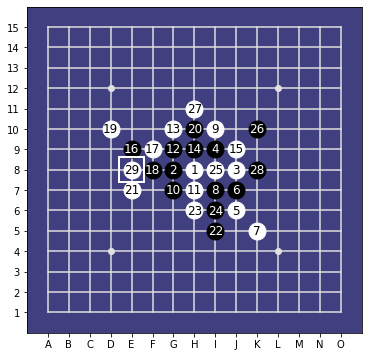

In [9]:
display(stones[:-2])

## Not 100% clear - hence not used

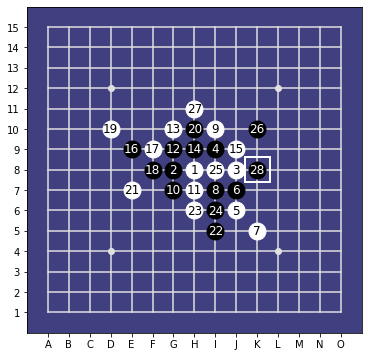

In [10]:
display(stones[:-3])

### Assembling the input tensor

In [11]:
borders = create_binary_rep(SIZE, [], current_color=0, padding=1, border=True)[:,:,1:]

input_batch = []
value_batch = []
stones_batch = []

# For all trajectories in the file
for trajectory in trajectories:

    trajectory = Gt._string_to_stones(trajectory)

    # the last move obviously wins
    winning_player = (len(trajectory) + 1) % 2

    # For all 2 almost-terminal subsequences (we don't learn from the terminal one itself!
    for sequence in [trajectory[:-1], trajectory[:-2]]:

        # For all symmetries
        symmetries = [data.transform(sequence, SIZE, rot, ref)
                      for rot in range(4)
                      for ref in [False, True]]

        current_player = len(sequence) % 2

        for symmetry in symmetries:

            # For manual validation purposes
            stones_batch.append(symmetry)

            signal = create_binary_rep(SIZE, symmetry, current_color=current_player, padding=1, border=False)
            input_tensor = np.concatenate([signal, borders], axis=2)
            input_batch.append(input_tensor)
            if current_player == winning_player:
                value_batch.append(1)
            else:
                value_batch.append(-1)

inputs = np.array(input_batch)
values = np.array(value_batch)

In [12]:
inputs.shape

(256, 17, 17, 3)

In [13]:
i = 0

### Sanity Check: All values correctly associated with their states?

1


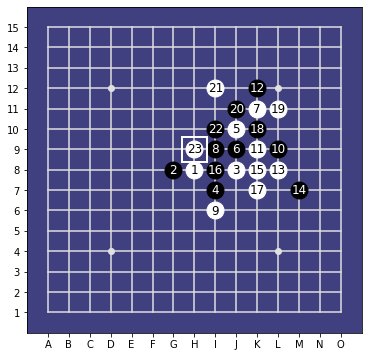

In [14]:
GomokuBoard(SIZE, stones=stones_batch[i]).display()
print(value_batch[i])
i += 1

# Looking at the terminal state

In [15]:
print(values[0])

1


### Channel 0: current (looser's) stones:

In [16]:
print(inputs[0, :, :, 0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Channel 1: other (=winner's) stones:

In [17]:
print(inputs[0, :, :, 1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Channel 2: Borders

In [18]:
print(inputs[0, :, :, 2])

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


# The Q-Function

In [19]:
layer1 = tf.keras.layers.Conv2D(
    filters=1, kernel_size=11,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.relu,
    padding='same',
    input_shape=(17, 17, 3))

layer2 = tf.keras.layers.Conv2D(
    filters=1, kernel_size=11,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.relu,
    padding='same',
    input_shape=(17, 17, 3))

layer3 = tf.keras.layers.Conv2D(
    filters=1, kernel_size=11,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.relu,
    padding='same',
    input_shape=(17, 17, 3))

layer4 = tf.keras.layers.Conv2D(
    filters=1, kernel_size=11,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.relu,
    padding='same',
    input_shape=(17, 17, 3))

aggregate = tf.keras.layers.Conv2D(
    filters=1, kernel_size=1,
    kernel_initializer=tf.random_normal_initializer(),
    bias_initializer=tf.random_normal_initializer(),
    activation=tf.nn.tanh,
    padding='same')



In [20]:
aggregate(layer4(layer3(layer2(layer1(inputs))))).shape

TensorShape([256, 17, 17, 1])

We could indeed optimize the Q Function rather than the value-function if we get a problem with Tensorflow's reduce_max. However, it appears, reduce_max is differentiable (Wow!) acorrding to [https://stackoverflow.com/questions/62715811/does-tf-math-reduce-max-allows-gradient-flow-like-torch-max](), and would indeed also funnel the gradients right into the relevant component of the underlying Q function

